# Image Captioning Model Trained on FLIKR Dataset

## Importing Libraries

In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = "Data"
WORKING_DIR = "."

In [3]:
## VGG19 Model

In [4]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, add
from tensorflow.keras.utils import plot_model

# Using VGG19 Model
model2 = VGG19()

# Creating a new model with VGG19 until the second last layer
vgg19_output = model2.layers[-2].output
model2 = Model(inputs=model2.inputs, outputs=vgg19_output)
print(model2.summary())

2023-12-27 01:29:22.614251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10034 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:65:00.0, compute capability: 8.6


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Extracting Image Features
### Using VGG16 Model

In [6]:
model = VGG16()

model = Model(inputs=model.inputs, outputs= model.layers[-2].output)

print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Extracting features from images

In [ ]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    #Loading the image from file
    img_path = directory + '/' + img_name
    #loading an image file into a PIL (Python Imaging Library) image object.
    image = load_img(img_path, target_size=(224,224))
    #converting image pixel to numpy array
    image = img_to_array(image)
    #Reshaping data for model
    image= image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
    #Preprocessing image for vgg model
    image = preprocess_input(image)
    # Extracting features
    feature = model.predict(image, verbose = 0)
    # Getting image ID
    image_id = img_name.split('.')[0]
    # Storing features
    features[image_id] = feature

## Storing features in pickle

In [ ]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'featuresVGG16flickr30k.pkl'), 'wb'))

## Loading features from pickle

In [5]:
with open(os.path.join(WORKING_DIR, 'featuresVGG19.pkl'), 'rb') as f:
    features = pickle.load(f)

## Loading the caption data

In [6]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f) #--> skipping the first lines which highlights the column names

    captions_doc = f.read()

In [7]:
captions_doc

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

## Creating mapping of images to captions

In [8]:
mapping = {}

# process lines
for line in tqdm(captions_doc.split('\n')):
    #splitting the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue

    image_id, caption = tokens[0], tokens[1:]
    #Removing extensions(jpg,png etc) from Image ID
    image_id = image_id.split('.')[0]
    # Converting caption list to string
    caption = " ".join(caption)
    # Creating list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # Storing the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

## Preprocessing the caption data

In [9]:
len(mapping)

8091

In [10]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            # Taking one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # Deleting digits, special characters etc
            caption = caption.replace('[^A-Za-z]', '')
            # Deleting additional spaces
            caption = caption.replace('\s+', ' ')
            # Adding start and end tages to the caption and also removing one letter words in the captions
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            # Saving the caption back to the dictionary
            captions[i] = caption
            

### Testing before and after preprocessing captions

In [11]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
clean(mapping)

In [13]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Combining all the captions in a single list

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## Tokinizing the text

The Tokenizer instance is used to process and convert text data into numerical sequences by 
assigning a unique integer (index) to each word in the vocabulary.

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
print('The vocabulary size after tokenizing all_captions is: ', vocab_size)

The vocabulary size after tokenizing all_captions is:  8485


##### Getting the max length of the caption available which will be used in padding the sequences further when creating the model

In [19]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

len(train) , len(test)

(7281, 810)

## Creating Dala Generator 

to get data in batch (avoiding session crash/out of memeroy error)

In [21]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    #Looping over the images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n+=1
            captions = mapping[key]
            # processing each caption
            for caption in captions:
                # Encoding the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Splitting the sequence into X,y pairs
                for i in range(1,len(seq)):
                    #Splitting into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    #padding input sequence
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    # Encoding output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    #Storing the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n== batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0


# Check tracking over each input to undertstand carefully

In [22]:
seq = tokenizer.texts_to_sequences([mapping['1000268201_693b08cb0e'][0]])
seq

[[1, 42, 3, 90, 172, 6, 119, 50, 393, 11, 394, 3, 27, 5146, 670, 2]]

In [23]:
mapping['1000268201_693b08cb0e'][0]

'startseq child in pink dress is climbing up set of stairs in an entry way endseq'

In [24]:
seq = tokenizer.texts_to_sequences([mapping['1000268201_693b08cb0e'][0]])[0]
seq

[1, 42, 3, 90, 172, 6, 119, 50, 393, 11, 394, 3, 27, 5146, 670, 2]

In [25]:
features['1000268201_693b08cb0e']

array([[0.      , 1.800772, 0.      , ..., 0.      , 0.      , 0.      ]],
      dtype=float32)

In [26]:
features['1000268201_693b08cb0e'][0]

array([0.      , 1.800772, 0.      , ..., 0.      , 0.      , 0.      ],
      dtype=float32)

## Model Creation

In [27]:
# Encoder model

# Image feature layers
inputs1 = Input(shape = (4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder Model

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs = [inputs1, inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer= 'adam')

# Plotting the model
# plot_model(model,show_shapes = True)

## VGG 19 model

In [ ]:
# # Encoder model
# # Image feature layers
# inputs1 = Input(shape=(4096,))
# fe1 = Dropout(0.4)(inputs1)
# fe2 = Dense(256, activation='relu')(fe1)

# # Sequence feature layers
# inputs2 = Input(shape=(max_length,))
# se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
# se2 = Dropout(0.4)(se1)
# se3 = LSTM(256)(se2)

# # Decoder Model
# decoder1 = add([fe2, se3])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)

# # Combining the VGG19 encoder and LSTM decoder
# model_output = model1(inputs1)
# combined_output = add([model_output, se3])
# decoder2 = Dense(256, activation='relu')(combined_output)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)

# # Creating the final model
# model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam')

# # Plotting the model
# plot_model(model, show_shapes=True)

## Training the model

In [28]:
epochs = 30
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # Creating data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # Fit for one epoch
    model.fit(generator, epochs = 1, steps_per_epoch=steps, verbose=1)

2023-12-27 01:30:06.822264: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_36/output/_23'
2023-12-27 01:30:07.507205: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9911885890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-27 01:30:07.507227: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A2000 12GB, Comp

113/113 [==============================] - 23s 202ms/step - loss: 2.0344


In [29]:
epochs = 50
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # Creating data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # Fit for one epoch
    model.fit(generator, epochs = 1, steps_per_epoch=steps, verbose=1)

2023-12-24 15:31:00.125288: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_36/output/_23'
2023-12-24 15:31:00.971807: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f953cfd4610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-24 15:31:00.971837: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A2000 12GB, Comp

113/113 [==============================] - 23s 203ms/step - loss: 1.7905


### Saving the model

In [30]:
model.save('goodmodel1.h5')

/home/salmanahmad/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
model.save('epoch50modelvgg19.h5')

/home/salmanahmad/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Generating captions for the images

In [30]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word

    return None

## Generating captions for the images

In [31]:
def predict_caption(model,image, tokenizer, max_length):
    # adding start tag for generation process
    in_text = 'startseq'
    # iterating over the max length of sequence
    for i in range(max_length):
        # encoding input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # padding the sequence 
        sequence = pad_sequences([sequence], max_length)
        # prediciting the next word
        yhat = model.predict([image,sequence], verbose = 0)
        # getting index with high probability
        yhat = np.argmax(yhat)
        # converting index to word
        word = idx_to_word(yhat, tokenizer)
        # stopping if word not found
        if word is None:
            break
        # appending as input for generating the next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

## validating with test data

In [35]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

for key in tqdm(test):
    # getting acutal captions
    captions = mapping[key]
    # predicting the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # splitting into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # appending to the lists
    actual.append(actual_captions)
    predicted.append(y_pred)

# calculating BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.540617
BLEU-2: 0.310976


In [51]:
# 50
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

for key in tqdm(test):
    # getting actual captions
    captions = mapping[key]
    # predicting the caption for the image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # splitting into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # appending to the lists
    actual.append(actual_captions)
    predicted.append(y_pred)

# calculating BLEU scores
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25,0.25,0.25,0.25)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.540617
BLEU-2: 0.310976
BLEU-3: 0.195564
BLEU-4: 0.117851


In [32]:
# 30
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

for key in tqdm(test):
    # getting actual captions
    captions = mapping[key]
    # predicting the caption for the image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # splitting into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # appending to the lists
    actual.append(actual_captions)
    predicted.append(y_pred)

# calculating BLEU scores
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25,0.25,0.25,0.25)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.522509
BLEU-2: 0.300207
BLEU-3: 0.186048
BLEU-4: 0.108721


# evaluation metrics for vgg19

In [70]:
# 30
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

for key in tqdm(test):
    # getting actual captions
    captions = mapping[key]
    # predicting the caption for the image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # splitting into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # appending to the lists
    actual.append(actual_captions)
    predicted.append(y_pred)

# calculating BLEU scores
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25,0.25,0.25,0.25)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.533080
BLEU-2: 0.308121
BLEU-3: 0.191177
BLEU-4: 0.113126


# evaluation metirc for vgg 19 50 epochs

In [31]:
# 30
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

for key in tqdm(test):
    # getting actual captions
    captions = mapping[key]
    # predicting the caption for the image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # splitting into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # appending to the lists
    actual.append(actual_captions)
    predicted.append(y_pred)

# calculating BLEU scores
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25,0.25,0.25,0.25)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.541623
BLEU-2: 0.316789
BLEU-3: 0.201546
BLEU-4: 0.123404


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw')
nltk.download('punkt')

In [ ]:
!pip install nltk

## Visualizing the Results

In [32]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # loading the image
    # image_name = "35506150_cbdb630f4f.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------------Actual-------------------------')
    for caption in captions:
        print(caption)
    # predicing the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('---------------------------Predicted-----------------------')
    print(y_pred)
    plt.imshow(image)

---------------------------Actual-------------------------
startseq man in red jacket is sitting on bench whilst cooking meal endseq
startseq "a man is sitting on bench cooking some food ." endseq
startseq man sits on bench endseq
startseq man wearing red jacket is sitting on wooden bench and is cooking something in small pot endseq
startseq man wearing red jacket sitting on bench next to various camping items endseq
---------------------------Predicted-----------------------
startseq man wearing red helmet is sitting on bench in the woods endseq


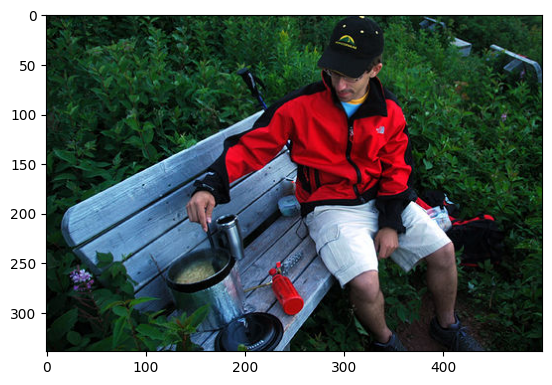

In [33]:
generate_caption("35506150_cbdb630f4f.jpg")

---------------------------Actual-------------------------
startseq brown dog is running through brown field endseq
startseq brown dog is running through the field endseq
startseq brown dog with collar runs in the dead grass with his tongue hanging out to the side endseq
startseq brown dog with his tongue wagging as he runs through field endseq
startseq dog running in the grass endseq
---------------------------Predicted-----------------------
startseq golden retriever is running through the grass with his tongue hanging out endseq


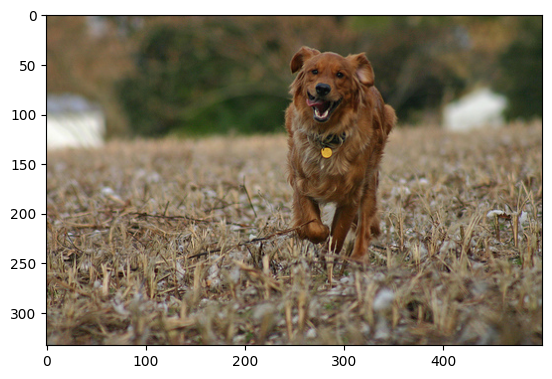

In [34]:
generate_caption("69189650_6687da7280.jpg")

---------------------------Actual-------------------------
startseq bike sits atop rise with mountains in the background endseq
startseq man wearing red uniform and helmet stands on his motorbike endseq
startseq motocross bike is being ridden over rocks endseq
startseq motocross biker about to descend endseq
startseq the motorcyclist has reached the summit endseq
---------------------------Predicted-----------------------
startseq motocross bike rider is riding up hill endseq


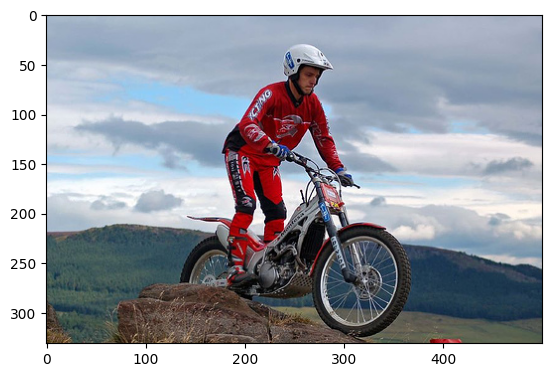

In [38]:
generate_caption("216172386_9ac5356dae.jpg")

## Testing with real images

In [39]:
vgg_model = VGG16() 
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs,             
                  outputs=vgg_model.layers[-2].output)

In [47]:
image_path = 'girl.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq woman wearing pink headscarf looks at her camera endseq'